In [1]:
import numpy as np
import cv2 as cv
from skimage import io
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Loading image
file = "../../images_test/picasso.jpg"
image = io.imread(file)

In [10]:
depth = cv.CV_16S
grad_x = cv.Sobel(src=image, ddepth=depth, dx=1, dy=0, ksize=5)
grad_y = cv.Sobel(src=image, ddepth=depth, dx=0, dy=1, ksize=5)

In [11]:
magnitude = np.sqrt(np.power(grad_x, 2, dtype=np.int32) + np.power(grad_y, 2, dtype=np.int32), dtype=np.float64)
direction = np.arctan2(grad_y, grad_x)

In [12]:
magnitude = (magnitude*255./magnitude.max()).round().astype(np.uint8)

Little bit of blur to smooth out the noise in the gradient

In [13]:
m_blurred_3 = cv.boxFilter(magnitude, ddepth=cv.CV_8U, ksize=(3, 3))
m_blurred_5 = cv.boxFilter(magnitude, ddepth=cv.CV_8U, ksize=(5, 5))
m_blurred_10 = cv.boxFilter(magnitude, ddepth=cv.CV_8U, ksize=(10, 10))

In [14]:
#magnitude = cv.boxFilter(magnitude, ddepth=cv.CV_8U, ksize=(3, 3))
#direction = cv.boxFilter(direction.astype('float64'), ddepth=cv.CV_16S, ksize=(3, 3))

In [15]:
m_blurred_10 = cv.boxFilter(m_blurred_10, ddepth=cv.CV_8U, ksize=(10, 10))

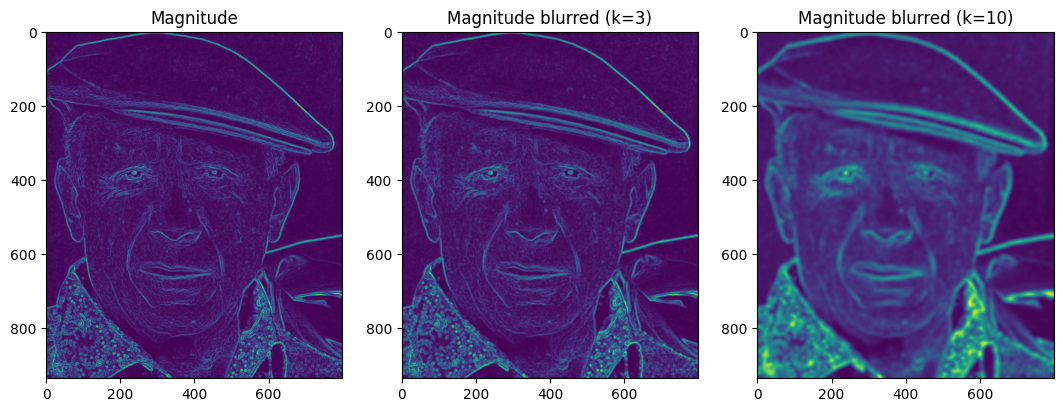

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))

axs[0].imshow(magnitude)
axs[1].imshow(m_blurred_3)
axs[2].imshow(m_blurred_10)

axs[0].set_title('Magnitude')
axs[1].set_title('Magnitude blurred (k=3)')
axs[2].set_title('Magnitude blurred (k=10)')

plt.show()

In [17]:
def getPoints(arr, n, inverse=False):
    shape = arr.shape
    weights = arr.flatten().astype(np.float64)
    if inverse:
        weights = weights.max() - weights
        weights = np.power(weights, 5)
    weights /= weights.sum()
    points_flat = np.random.choice(len(weights), size=n, p=weights)
    points_row, points_col = np.unravel_index(points_flat, shape=shape)
    return points_row, points_col

In [18]:
n = 30000
points_row, points_col = getPoints(m_blurred_10, n, inverse=True)

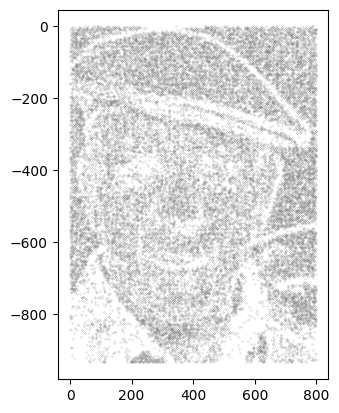

In [19]:
marker = matplotlib.markers.MarkerStyle('.').scaled(0.05)
plt.scatter(points_col, -points_row, marker=marker, edgecolors='grey')
plt.gca().set_aspect(image.shape[0]/image.shape[1])

In [20]:
d_blurred_10 = cv.boxFilter(direction.astype('float64'), ddepth=cv.CV_16S, ksize=(10, 10))

In [21]:
d_blurred_10 = cv.boxFilter(d_blurred_10, ddepth=cv.CV_16S, ksize=(10, 10))

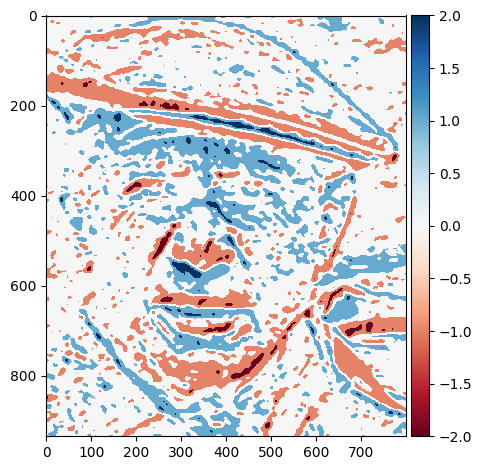

In [22]:
io.imshow(d_blurred_10)

In [24]:
from matplotlib.collections import LineCollection

In [25]:
#length = 10.
segments = []
add_lengths = np.power((m_blurred_10.max() - m_blurred_10) / 255., 7)
for k in range(n):
    j = points_col[k]
    i = points_row[k]
    x0 = j + np.random.rand()
    y0 = i + np.random.rand()
    angle = d_blurred_10[i, j] + np.pi/2
    length = 5000. * (add_lengths[i, j])
    x1 = x0 + np.cos(angle + 0.2 * np.random.rand()) * length
    y1 = y0 + np.sin(angle + 0.2 * np.random.rand()) * length
    line = [(x0, -y0), (x1, -y1)]
    segments.append(line)

In [26]:
segs = np.array(segments)

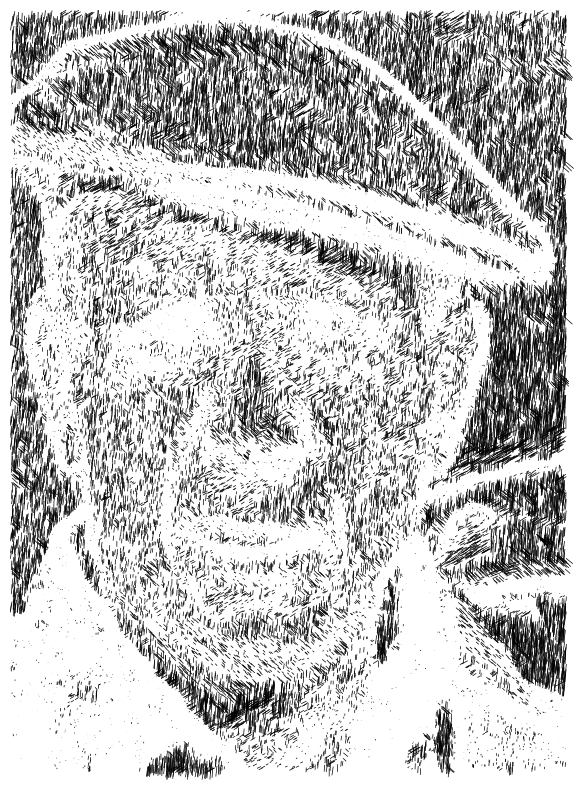

In [28]:
line_segments = LineCollection(segs, linewidths=0.5, colors='black', linestyle='solid')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(image.shape[0]/image.shape[1])
ax.set_xlim(segs[:,:,0].min(), segs[:,:,0].max())
ax.set_ylim(segs[:,:,1].min(), segs[:,:,1].max())
ax.add_collection(line_segments)
plt.axis('off')
plt.savefig("picasso_lines.png")
plt.show()

(array([ 30671.,  25071.,  24838.,  29495.,  44637.,  60694.,  86809.,
        119106., 180147., 146532.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

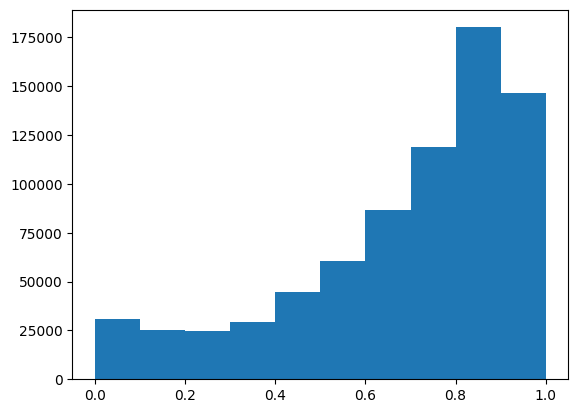

In [31]:
plt.hist(np.power((magnitude.max() - magnitude).flatten() / 255., 6))